# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [15]:
import pandas as pd
import numpy as np
from scapy.all import *

netflix_packets = rdpcap('netflix.pcap')

print(netflix_packets)

<netflix.pcap: TCP:141143 UDP:232 ICMP:16 Other:80>


In [6]:
for i in range(10):
    print(netflix_packets[i].summary())
    print(netflix_packets[i].layers())

#layers: Ether, IP, UDP, DNS Qry

Ether / IP / UDP / DNS Qry "b'fonts.gstatic.com.'" 
[<class 'scapy.layers.l2.Ether'>, <class 'scapy.layers.inet.IP'>, <class 'scapy.layers.inet.UDP'>, <class 'scapy.layers.dns.DNS'>]
Ether / IP / UDP / DNS Qry "b'fonts.gstatic.com.'" 
[<class 'scapy.layers.l2.Ether'>, <class 'scapy.layers.inet.IP'>, <class 'scapy.layers.inet.UDP'>, <class 'scapy.layers.dns.DNS'>]
Ether / IP / UDP / DNS Qry "b'googleads.g.doubleclick.net.'" 
[<class 'scapy.layers.l2.Ether'>, <class 'scapy.layers.inet.IP'>, <class 'scapy.layers.inet.UDP'>, <class 'scapy.layers.dns.DNS'>]
Ether / IP / UDP / DNS Qry "b'googleads.g.doubleclick.net.'" 
[<class 'scapy.layers.l2.Ether'>, <class 'scapy.layers.inet.IP'>, <class 'scapy.layers.inet.UDP'>, <class 'scapy.layers.dns.DNS'>]
Ether / IP / UDP / DNS Qry "b'ytimg.l.google.com.'" 
[<class 'scapy.layers.l2.Ether'>, <class 'scapy.layers.inet.IP'>, <class 'scapy.layers.inet.UDP'>, <class 'scapy.layers.dns.DNS'>]
Ether / IP / UDP / DNS Qry "b'r4---sn-gxo5uxg-jqbe.googlevideo.c

### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [ ]:
test = str(netflix_packets[1])
#if netflix_packets[1].contains('DNS Qry'):
if 'DNS' in test:
    print("yes")

print(netflix_packets[8].summary())
#print(netflix_packets[8].summary().split("'"))
print(netflix_packets[8].summary().split('"'))
print((netflix_packets[8].summary()).split('"')[1])

yes
Ether / IP / UDP / DNS Ans "216.58.213.162" 
['Ether / IP / UDP / DNS Ans ', '216.58.213.162', ' ']
216.58.213.162
Looking for DNS responses...
Total DNS responses found: 62
  - Ether / IP / UDP / DNS Ans "216.58.213.162" 
  - Ether / IP / UDP / DNS Ans "2a00:1450:4007:805::2003" 
  - Ether / IP / UDP / DNS Ans "172.217.18.195" 

Checking for Netflix DNS responses...


In [ ]:
netflix_domains = ['netflix.com', 'netflix.net', 'nflxso.net', 'nflxvideo.net', 'nflxext.com', 'nflximg.com', 'nflximg.net']
#source: https://www.netify.ai/resources/applications/netflix

all_dns_packets = []

for packet in netflix_packets:
    packet_summary = packet.summary()

    if 'DNS' in packet_summary:
        all_dns_packets.append(packet_summary)

print(f"total DNS packets: {len(all_dns_packets)}\n")
print("first 10 DNS packets:")

for i, packet in enumerate(all_dns_packets[:10]):
    print(f"{i}: {packet}")

print("\nnetflix packets:\n")
for packet in netflix_packets:
    packet_summary = packet.summary()

    for domain in netflix_domains:
        if domain in packet_summary and 'DNS' in packet_summary:
            print(packet_summary)

total DNS packets: 168

first 10 DNS packets:
0: Ether / IP / UDP / DNS Qry "b'fonts.gstatic.com.'" 
1: Ether / IP / UDP / DNS Qry "b'fonts.gstatic.com.'" 
2: Ether / IP / UDP / DNS Qry "b'googleads.g.doubleclick.net.'" 
3: Ether / IP / UDP / DNS Qry "b'googleads.g.doubleclick.net.'" 
4: Ether / IP / UDP / DNS Qry "b'ytimg.l.google.com.'" 
5: Ether / IP / UDP / DNS Qry "b'r4---sn-gxo5uxg-jqbe.googlevideo.com.'" 
6: Ether / IP / UDP / DNS Qry "b'ssl.gstatic.com.'" 
7: Ether / IP / UDP / DNS Qry "b'www.google.com.'" 
8: Ether / IP / UDP / DNS Ans "216.58.213.162" 
9: Ether / IP / UDP / DNS Qry "b'www.gstatic.com.'" 

netflix packets:

Ether / IP / UDP / DNS Qry "b'www.netflix.com.'" 
Ether / IP / UDP / DNS Qry "b'assets.nflxext.com.'" 
Ether / IP / UDP / DNS Qry "b'codex.nflxext.com.'" 
Ether / IP / UDP / DNS Qry "b'customerevents.netflix.com.'" 
Ether / IP / UDP / DNS Qry "b'ipv4-c001-cdg001-ix.1.oca.nflxvideo.net.'" 
Ether / IP / UDP / DNS Qry "b'ipv4-c024-cdg001-ix.1.oca.nflxvideo.net

In [22]:
"""
netflix_domains = ['netflix.com', 'netflix.net', 'nflxso.net', 'nflxvideo.net', 'nflxext.com', 'nflximg.com', 'nflximg.net']
#source: https://www.netify.ai/resources/applications/netflix

netflix_traffic = []
#do domains in a bit

netflix_traffic_ips = []

for packet in netflix_packets:
    #packet_string_form = str(packet)
    packet_summary = packet.summary()

    #if 'DNS Qry' in packet_string_form:
    #if 'DNS' in packet_string_form:
    if 'DNS' in packet_summary:
        #packet_summary = packet.summary()
        #netflix_traffic.append(packet_summary)

        for domain in netflix_domains:
            #if ('netflix.com' in packet_summary) | ('netflix.net' in packet_summary) | ('nflxvideo.net' in packet_summary):
            if domain in packet_summary:
                netflix_traffic.append(packet_summary)

                if 'DNS Ans' in packet_summary:
                    #ip_addr = packet_summary.split("'")[1]
                    parts = packet_summary.split('"')

                    if len(parts) > 1:
                        ip_addr = parts[1]

                        if ip_addr not in netflix_traffic_ips:
                            netflix_traffic_ips.append(ip_addr)

#print(netflix_traffic)
print(netflix_traffic_ips) #um??
"""
netflix_queries = []

for packet in netflix_packets:
    packet_summary = packet.summary()

    for domain in netflix_domains:
        if domain in packet_summary:

            if 'DNS Qry' in packet_summary:
                netflix_queries.append(packet_summary)

print(f"found {len(netflix_queries)} netflix DNS queries\n")
print(netflix_queries)

found 18 netflix DNS queries

['Ether / IP / UDP / DNS Qry "b\'www.netflix.com.\'" ', 'Ether / IP / UDP / DNS Qry "b\'assets.nflxext.com.\'" ', 'Ether / IP / UDP / DNS Qry "b\'codex.nflxext.com.\'" ', 'Ether / IP / UDP / DNS Qry "b\'customerevents.netflix.com.\'" ', 'Ether / IP / UDP / DNS Qry "b\'ipv4-c001-cdg001-ix.1.oca.nflxvideo.net.\'" ', 'Ether / IP / UDP / DNS Qry "b\'ipv4-c024-cdg001-ix.1.oca.nflxvideo.net.\'" ', 'Ether / IP / UDP / DNS Qry "b\'ipv4-c072-cdg001-ix.1.oca.nflxvideo.net.\'" ', 'Ether / IP / UDP / DNS Qry "b\'occ-0-56-55.1.nflxso.net.\'" ', 'Ether / IP / UDP / DNS Qry "b\'tp-s.nflximg.net.\'" ', 'Ether / IP / UDP / DNS Qry "b\'push.prod.netflix.com.\'" ', 'Ether / IP / UDP / DNS Qry "b\'ipv4-c005-cdg001-ix.1.oca.nflxvideo.net.\'" ', 'Ether / IP / UDP / DNS Qry "b\'ipv4-c069-cdg001-ix.1.oca.nflxvideo.net.\'" ', 'Ether / IP / UDP / DNS Qry "b\'ipv4-c071-cdg001-ix.1.oca.nflxvideo.net.\'" ', 'Ether / IP / UDP / DNS Qry "b\'ipv4-c063-cdg001-ix.1.oca.nflxvideo.net.\'" ',

I was able to identify Netflix traffic by detecting 18 DNS queries for netflix domains, confirming that the service was being access. However, the packet capture seems incomplete because it only contains the queries, it's missing the corresponding DNS response packets. While other DNS answers are present in the capture, like the one for google.com in the first 10 packets, they don't correspond to the Netflix queries specifically. Thus, it's confirmed that Netflix was being used, but the specific IP addresses of the Netflix servers can't be extracted

### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [3]:
from netml.pparser.parser import PCAP
from netml.utils.tool import dump_data, load_data

print("getting pcap...\n")
netflix_pcap = PCAP('netflix.pcap')

print("pcap2pandas...\n")
netflix_pcap.pcap2pandas()

print("pcap2flows...\n")
netflix_pcap.pcap2flows()

print("pcap features...\n")
netflix_pcap.flow2features('IAT', fft = False, header = False)

getting pcap...

pcap2pandas...

pcap2flows...

pcap features...



In [4]:
#um features?
print("getting features\n")
netflix_features = netflix_pcap.features
print(netflix_features.shape)
print(len(netflix_pcap.flows))

getting features

(184, 359)
184


In [5]:
#stats
print("feature stats:\n")
print(f"min: {np.min(netflix_features, axis = 0)}\n")
print(f"max: {np.max(netflix_features, axis = 0)}\n")
print(f"mean: {np.mean(netflix_features, axis = 0)}\n")
print(f"std: {np.std(netflix_features, axis = 0)}\n")

feature stats:

min: [0.01274514 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0

**Write a brief justification for the features that you have chosen.**

The features I chose are able to track timing patterns, since video streaming sends packets in bursts, but if the video quality is bad the timing becomes messy and very irregular, so these features observe and measure the timing patterns to spot any problems or issues. Good video streams have steady data flow, while poor quality streams have uneven flow, so my features can detect these differences in how data moves. The features are also able to see different video issues, like if a video freezes (unusual gaps between packets), a difference in quality (there would be different patterns in the data flow), and buffering (abnormal timing).

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [6]:
"""
Segment definition:
 For the “segment downloads rate” feature, you can define a segment as a burst of packets separated by at least a 1-second gap.
 The number of such segments within a given time window can then be used as your “segment downloads rate” feature, e.g., x segments/second

 um 10 second widows??
"""

sorted_packets = sorted(netflix_packets, key = lambda x: x.time)
start = sorted_packets[0].time

segments = []
seg_in_curr = 0
in_burst = False

for i, packet in enumerate(sorted_packets):
    idx = int((packet.time - start) / 10)

    if idx >= len(segments):
        if len(segments) > 0:
            segments.append(seg_in_curr)
        else:
            segments.append(0)

        seg_in_curr = 0

    if i > 0:
        gap = packet.time - sorted_packets[i - 1].time

        if gap > 1:
            if in_burst:
                seg_in_curr += 1
                in_burst = False
            else:
                in_burst = True
        else:
            in_burst = True

if in_burst:
    seg_in_curr += 1

if (seg_in_curr > 0) or (len(segments) == 0):
    segments.append(seg_in_curr)

print(segments)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2, 0, 0, 2, 2, 3, 3, 3, 3, 2, 2, 4, 4, 3, 3, 3, 3, 2, 2, 3, 3, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 3, 2]


In [ ]:
#um time windows?
start = netflix_packets[0].time
size = 10

"""
time_windows = []

for packet in netflix_packets:
    idx = int((packet.time - start) / size)

    if idx not in time_windows:
        time_windows[idx] = []

    time_windows[idx].append(packet)
"""

time_windows = {}

for packet in netflix_packets:
    idx = int((packet.time - start) / size)

    if idx not in time_windows:
        time_windows[idx] = []

    time_windows[idx].append(packet)

segments = []

for idx in sorted(time_windows):
    packets = sorted(time_windows[idx], key = lambda x: x.time)
    segments_in_window = 0
    in_burst = False

    for i in range(1, len(packets)):
        gap = packets[i].time - packets[i - 1].time

        if gap > 1.0:
            if in_burst:
                segments_in_window += 1
                in_burst = False
            else:
                in_burst = True

    if in_burst:
        segments_in_window += 1

    segments.append(segments_in_window)

print(segments)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [1]:
import pickle

with open('netflix_dataset.pkl', 'rb') as file:
    pickle_content = pickle.load(file)
    #print(f"type: {type(pickle_content)}")
    #dataframe

    print(pickle_content)

                                       10_EWMA_chunksizes  10_avg_chunksize  \
208     [[4380.0], [4380.0], [19682.095238095237], [23...          148947.1   
209     [[179260.0], [130204.0], [49666.09523809524], ...           91984.2   
210     [[317962.0], [83192.4], [170850.7619047619], [...          147725.0   
211     [[396800.0], [98961.6], [246910.09523809524], ...          246420.6   
212     [[325264.0], [331102.4], [365584.38095238095],...          336681.0   
...                                                   ...               ...   
200634  [[589034.0], [533811.6], [571466.7619047619], ...          495682.8   
200635  [[195178.0], [486315.6], [641802.380952381], [...          558961.0   
200636  [[476568.0], [521363.2], [272839.61904761905],...          599166.8   
200637  [[615578.0], [565381.2], [707327.7142857143], ...          692610.4   
200638  [[615578.0], [565381.2], [707327.7142857143], ...          692610.4   

        10_chunksizes_50  10_chunksizes_50R  10_chu

### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [2]:
"""
cols = pickle_content.columns

if 'resolution' in cols:
    print("yes")

for i, col in enumerate(cols):
    print(f"Index {i}: '{col}'")
"""
#Index 96: 'resolution'
valid_resolutions = [240, 360, 480, 720, 1080]
cleaned_pickle = pickle_content[pickle_content['resolution'].isin(valid_resolutions)]

print(cleaned_pickle['resolution'])
print(cleaned_pickle)

208       360.0
209       360.0
210       360.0
211       360.0
212       480.0
          ...  
200633    480.0
200634    480.0
200635    480.0
200636    480.0
200637    480.0
Name: resolution, Length: 49748, dtype: float64
                                       10_EWMA_chunksizes  10_avg_chunksize  \
208     [[4380.0], [4380.0], [19682.095238095237], [23...          148947.1   
209     [[179260.0], [130204.0], [49666.09523809524], ...           91984.2   
210     [[317962.0], [83192.4], [170850.7619047619], [...          147725.0   
211     [[396800.0], [98961.6], [246910.09523809524], ...          246420.6   
212     [[325264.0], [331102.4], [365584.38095238095],...          336681.0   
...                                                   ...               ...   
200633  [[566340.0], [269408.8], [527273.3333333334], ...          498288.4   
200634  [[589034.0], [533811.6], [571466.7619047619], ...          495682.8   
200635  [[195178.0], [486315.6], [641802.380952381], [...        

2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [3]:
"""
for i, col in enumerate(cleaned_pickle.columns):
    print(f"Index {i}: '{col}'")

Could not convert ['badbadbadbadbadbadbadbadbadbadbadbadbadbadgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgoodgo
"""
cols_to_remve = ['absolute_timestamp',
                 'chunk_start_time',
                 'chunk_end_time',
                 'deployment_session_id',
                 'home_id',
                 'index',
                 'relative_timestamp',
                 'session_id',
                 'video_id']

temp_cleaned = cleaned_pickle.drop(columns = cols_to_remve)

remove_pt_2 = []

for col in cleaned_pickle.columns:
    if col == 'resolution':
        continue

    if col in cols_to_remve:
        continue

    ewma = 'EWMA' in col
    listt = 'list' in col
    array = 'array' in col

    if ewma or listt or array:
        remove_pt_2.append(col)
        continue

    if col in temp_cleaned.columns:
        #col_type = col.dtype
        col_type = cleaned_pickle[col].dtype

        if len(temp_cleaned) > 0:
            test = temp_cleaned[col].iloc[0]
        else:
            test = None

        if (col_type == 'object') or isinstance(test, str) or isinstance(test, list) or ((isinstance(test, str) and ('bad' in test) and ('good' in test))):
            remove_pt_2.append(col)

final_cleaned = temp_cleaned.drop(columns = remove_pt_2)

print(final_cleaned)

        10_avg_chunksize  10_chunksizes_50  10_chunksizes_50R  \
208             148947.1           43473.0            43473.0   
209              91984.2          101882.0           101882.0   
210             147725.0          111373.0           111373.0   
211             246420.6          297522.0           297522.0   
212             336681.0          354461.0           354461.0   
...                  ...               ...                ...   
200633          498288.4          562720.0           562720.0   
200634          495682.8          545831.0           545831.0   
200635          558961.0          555966.0           555966.0   
200636          599166.8          584205.0           584205.0   
200637          692610.4          689184.0           689184.0   

        10_chunksizes_75  10_chunksizes_75R  10_chunksizes_85  \
208             185098.0           185098.0          361832.3   
209             122323.0           122323.0          159843.4   
210             224157.0

**Briefly explain why you removed those columns.**

absolute_timestamp & relative_timestamp: these are just specific time points that won't necessarily help to predict video quality since it's just remembering what happened at a specific time, not really useful for patterns

chunk_start_time & chunk_end_time: we don't need the exact timing of video chunks because the exact timing doesn't necessarily cause good or bad quality, which is more impacted by network issues

deployment_session_id, session_id, & home_id: unique identifiers aren't useful and causes the model to memorize specifics instead of learning the patterns

index: this is just the row number, and won't help the model training process at all

video_id: model doesn't need to know which specific video is playing

all of the above columns I removed are ones that won't help the new model at all because they're specific to individual times or videos instead of representing the overall patterns that cause good and poor video quality. training the model on these specifics won't really benefit it all

I also removed 'object' type columns like strings and mixed types, or any containing Python 'list' and 'array' objects since they can't be directly used by the model. There were some columns I encountered that had long string patterns like 'badbadbadbadb...goodgoodgood' which seems to be encoded binary data that wasn't properly parsed. Some columns had string values that couldn't be converted to numerical values, so I removed the ones where the first value is a string, which would indicate non-numeric content. When running the data preparation code, there was also an issue with a column titled 'EWMA', so I removed that one too.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#target var = 'resolution'?
features = final_cleaned.drop(columns = ['resolution'])
labels = final_cleaned['resolution']

print(features.shape)
print(labels.shape)

if features.isnull().sum().sum() > 0:
    print("missing features detected")
    features = features.fillna(features.mean())

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42, stratify = labels)

print(x_train.shape)
print(x_test.shape)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape)
print(x_test_scaled.shape)

(49748, 238)
(49748,)
missing features detected
(39798, 238)
(9950, 238)
(39798, 238)
(9950, 238)


### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [7]:
#model: random forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth = 10, min_samples_split = 5, min_samples_leaf = 2)
rf_model.fit(x_train_scaled, y_train)

train_predictions = rf_model.predict(x_train_scaled)
train_accuracy = accuracy_score(y_train, train_predictions)

print(f"train accuracy: {train_accuracy:.4f}")

test_predictions = rf_model.predict(x_test_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"test accuracy: {test_accuracy:.4f}")

print(classification_report(y_test, test_predictions, target_names=['240p', '360p', '480p', '720p', '1080p']))

train accuracy: 0.9268
test accuracy: 0.9089
              precision    recall  f1-score   support

        240p       0.80      0.50      0.61       340
        360p       0.91      0.76      0.82       895
        480p       0.90      0.98      0.94      5897
        720p       0.94      0.79      0.86      1892
       1080p       0.97      0.99      0.98       926

    accuracy                           0.91      9950
   macro avg       0.90      0.80      0.84      9950
weighted avg       0.91      0.91      0.90      9950



### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [9]:
from sklearn.model_selection import RandomizedSearchCV
#source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

new_rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth = 10, min_samples_split = 5, min_samples_leaf = 2)

distribution = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

randm_search = RandomizedSearchCV(
    estimator = new_rf_model,
    param_distributions = distribution,
    n_iter = 10,
    cv = 3,
    scoring = 'accuracy',
    random_state = 42,
    verbose = 1
)

randm_search.fit(x_train_scaled, y_train)

print("best parameters:\n")
print(randm_search.best_params_)

best_model = randm_search.best_estimator_
faster_test_predictions = best_model.predict(x_test_scaled)
fast_accuracy = accuracy_score(y_test, faster_test_predictions)

print(f"better accuracy: {fast_accuracy:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
best parameters:

{'n_estimators': 150, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 15}
better accuracy: 0.9413


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

accuracy: 0.9413
f1 score: 0.9392
f1 scores per class:

240p: 0.6760
360p: 0.8722
480p: 0.9618
720p: 0.9270
1080p: 0.9813


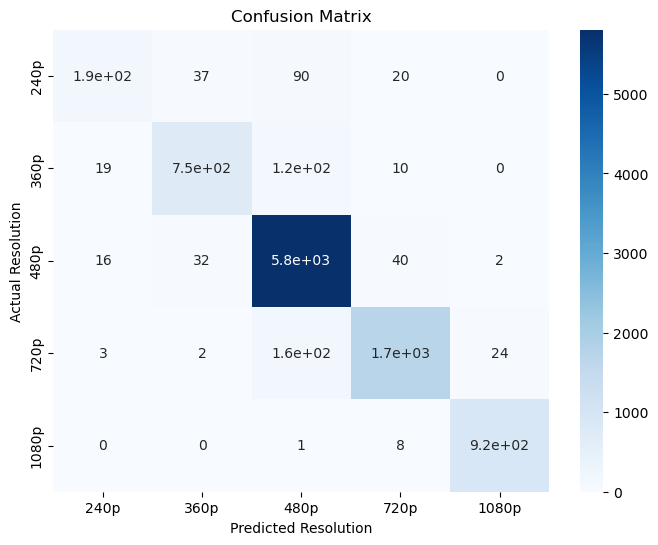

confusion matrix:

[[ 193   37   90   20    0]
 [  19  747  119   10    0]
 [  16   32 5807   40    2]
 [   3    2  161 1702   24]
 [   0    0    1    8  917]]

auc score: 0.9938


In [12]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

#accuracy
faster_accuracy = accuracy_score(y_test, faster_test_predictions)
print(f"accuracy: {faster_accuracy:.4f}")

#f1 score
f1 = f1_score(y_test, faster_test_predictions, average = 'weighted')
print(f"f1 score: {f1:.4f}")

per_class = f1_score(y_test, faster_test_predictions, average = None)
resolutions = ['240p', '360p', '480p', '720p', '1080p']
print("f1 scores per class:\n")
for resolution, score in zip(resolutions, per_class):
    print(f"{resolution}: {score:.4f}")

#confusion matrix
matrix = confusion_matrix(y_test, faster_test_predictions)
plt.figure(figsize = (8,6))
sns.heatmap(matrix, annot = True, cmap = 'Blues', xticklabels=resolutions, yticklabels=resolutions)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Resolution")
plt.ylabel("Actual Resolution")
plt.show()

print("confusion matrix:\n")
print(matrix)

#roc auc score
probability = best_model.predict_proba(x_test_scaled)
auc_score = roc_auc_score(y_test, probability, multi_class='ovr')
print(f"\nauc score: {auc_score:.4f}")

The model has an accuracy of 94.13% and an F1-score of 93.92%, which are strong indicators that the model is correctly classifying the vast majority of instances. The high AUC score of 0.9938 also confirms that the model is able to distinguish between the different resolution classes.

The model is exceptionally good at identifying 480p, 720p, and 1080p resolutions, which are likely the most common classes in the dataset. The model's high precision and F1-scores for those three categories are the primary reason for the high overall accuracy. Although not as high as the other 3, the F1-score of 0.87 for 360p means it handles that case pretty well too. For AUC scores, a 1 is perfect, so my AUC score of 0.9938 means there's a very high probability that my mdel will rank a random positive instance higher than a random negative instance.

The main area for improvement lies in the performance for the 240p category. It has the lowest F1-score, significantly, at 0.676. Looking at the confusion matrix, we can see that the model predicted 90 instances of actual 240p as 480p, and 37 as 360p, which suggests the visual features the model uses to identify 240p are not distinct enough from those of 360p and 480p. This is understandable as these are lower-resolution categories, so they could share similar traits. There was also a lot of 720p videos that were misclassified as 480p, 161 to be exact, which is the second largest source of error, indicating that some 720p videos have features that are close to 480p.

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

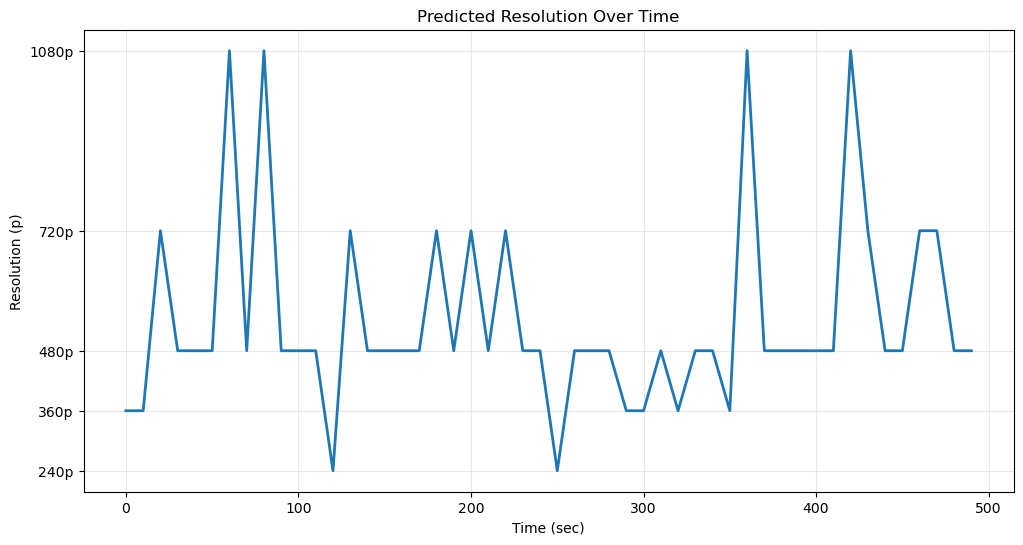

In [14]:
pt3_predictions = best_model.predict(x_test_scaled)

"""
time_intervals = []

for i in range(len(pt3_predictions)):
    time_intervals.append(i * 10)
"""

sample_size = 50
time_intervals = []

for i in range(sample_size):
    time_intervals.append(i * 10)

sample_predictions = pt3_predictions[:sample_size]

plt.figure(figsize=(12, 6))
plt.plot(time_intervals, sample_predictions, linewidth = 2)
plt.title("Predicted Resolution Over Time")
plt.xlabel("Time (sec)")
plt.ylabel("Resolution (p)")
plt.yticks([240, 360, 480, 720, 1080], ['240p', '360p', '480p', '720p', '1080p'])
plt.grid(True, alpha=0.3)
plt.show()

The above graph shows the predicted video resolution of a Netflix session over a 500 second period. The resolution fluctuates between 480p and 1080p, starting at 480p, quickly jumpting to 1080p, then dropping back to 480p around the 200 second mark, and finally returning to 1080p for the remainder of the session. This pattern seems to demonstrate that the video quality automatically adjusts based on network conditions to provide the best possible viewing experience for the user.

I also chose to use a sample of 50 predictions (500 seconds) instead of all predictions for two key reasons:

1. Using the full test set would mean multiple sessions totaling 27+ hours, which seems unrealistic for a viewing session. This 8.3 minute sample, while significantly shorter than an average Netflix episode of 40-60 min, this does provide a more authentic representation of typical streaming behavior.

2. Plotting all the predictions would create an overcrowded and unreadable graph that obscures the changes. This smaller sample clearly shows the streaming behavor, and makes it easier for us to analyze